# 「画像」 > 「事前にトレーニングされたCNNによる転移学習」を選びました

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

Using TensorFlow backend.


In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds

In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
                                                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                            with_info=True,
                                                            as_supervised=True,)

In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


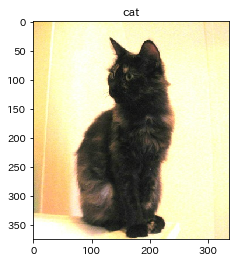

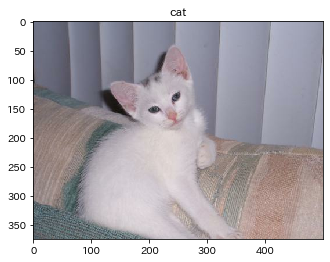

In [7]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## ImageNetデータセットで学習されたMobileNet V2 モデル（googleで開発された）を使用する。include_top=Falseとすることで全結合層を含めない。

In [19]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

## 160x160x3の各画像を5x5x1280に変換する。

In [20]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## base_model.trainable = Falseとすることで学習済みのモデルの重みを更新しないようにする

In [29]:
base_model.trainable = False

In [30]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 10, 10, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 10, 10, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 10, 10, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 10, 10, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [32]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [33]:
K.clear_session()
model = tf.keras.Sequential([base_model, global_average_layer, prediction_layer])

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
len(model.trainable_variables)

2

## ベースラインを計算する

In [37]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - ETA: 2:15 - loss: 0.8752 - accuracy: 0.34 - ETA: 1:10 - loss: 0.8251 - accuracy: 0.42 - ETA: 49s - loss: 0.8451 - accuracy: 0.4062 - ETA: 38s - loss: 0.8578 - accuracy: 0.414 - ETA: 32s - loss: 0.8905 - accuracy: 0.418 - ETA: 27s - loss: 0.9041 - accuracy: 0.375 - ETA: 23s - loss: 0.9004 - accuracy: 0.392 - ETA: 20s - loss: 0.9008 - accuracy: 0.398 - ETA: 17s - loss: 0.9029 - accuracy: 0.392 - ETA: 15s - loss: 0.9294 - accuracy: 0.368 - ETA: 13s - loss: 0.9209 - accuracy: 0.380 - ETA: 11s - loss: 0.9202 - accuracy: 0.380 - ETA: 9s - loss: 0.9221 - accuracy: 0.377 - ETA: 8s - loss: 0.9220 - accuracy: 0.37 - ETA: 6s - loss: 0.9173 - accuracy: 0.37 - ETA: 5s - loss: 0.9192 - accuracy: 0.35 - ETA: 4s - loss: 0.9167 - accuracy: 0.35 - ETA: 2s - loss: 0.9130 - accuracy: 0.35 - ETA: 1s - loss: 0.9122 - accuracy: 0.36 - 25s 1s/step - loss: 0.9112 - accuracy: 0.3562


In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.91
initial accuracy: 0.36


In [39]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10


    174/Unknown - 14s 14s/step - loss: 0.8595 - accuracy: 0.40 - 15s 7s/step - loss: 0.8256 - accuracy: 0.4531 - 16s 5s/step - loss: 0.8249 - accuracy: 0.395 - 17s 4s/step - loss: 0.8237 - accuracy: 0.382 - 18s 4s/step - loss: 0.8075 - accuracy: 0.400 - 19s 3s/step - loss: 0.8039 - accuracy: 0.427 - 21s 3s/step - loss: 0.7963 - accuracy: 0.424 - 22s 3s/step - loss: 0.7924 - accuracy: 0.441 - 23s 3s/step - loss: 0.7889 - accuracy: 0.437 - 24s 2s/step - loss: 0.7743 - accuracy: 0.471 - 25s 2s/step - loss: 0.7775 - accuracy: 0.465 - 26s 2s/step - loss: 0.7754 - accuracy: 0.474 - 27s 2s/step - loss: 0.7679 - accuracy: 0.473 - 28s 2s/step - loss: 0.7642 - accuracy: 0.473 - 29s 2s/step - loss: 0.7584 - accuracy: 0.475 - 30s 2s/step - loss: 0.7638 - accuracy: 0.474 - 31s 2s/step - loss: 0.7566 - accuracy: 0.483 - 32s 2s/step - loss: 0.7602 - accuracy: 0.480 - 33s 2s/step - loss: 0.7589 - accuracy: 0.483 - 34s 2s/step - loss: 0.7540 - accuracy: 0.489 - 35s 2s/step - loss: 0.7527 - accuracy: 0.

582/582 [==============================].3942 - accuracy: 0.80 - 574s 1s/step - loss: 0.3939 - accuracy: 0.80 - 575s 1s/step - loss: 0.3938 - accuracy: 0.80 - 577s 1s/step - loss: 0.3936 - accuracy: 0.80 - 577s 1s/step - loss: 0.3933 - accuracy: 0.80 - 579s 1s/step - loss: 0.3929 - accuracy: 0.80 - 580s 1s/step - loss: 0.3925 - accuracy: 0.80 - 581s 1s/step - loss: 0.3924 - accuracy: 0.80 - 582s 1s/step - loss: 0.3921 - accuracy: 0.80 - 583s 1s/step - loss: 0.3919 - accuracy: 0.80 - 584s 1s/step - loss: 0.3915 - accuracy: 0.80 - 585s 1s/step - loss: 0.3914 - accuracy: 0.80 - 586s 1s/step - loss: 0.3910 - accuracy: 0.80 - 587s 1s/step - loss: 0.3907 - accuracy: 0.80 - 588s 1s/step - loss: 0.3904 - accuracy: 0.80 - 589s 1s/step - loss: 0.3904 - accuracy: 0.80 - 590s 1s/step - loss: 0.3902 - accuracy: 0.80 - 591s 1s/step - loss: 0.3898 - accuracy: 0.80 - 592s 1s/step - loss: 0.3896 - accuracy: 0.80 - 593s 1s/step - loss: 0.3893 - accuracy: 0.80 - 594s 1s/step - loss: 0.3891 - accuracy: 0.

185/582 [========>.....................] - ETA: 31:20 - loss: 0.1626 - accuracy: 0.937 - ETA: 20:26 - loss: 0.2004 - accuracy: 0.875 - ETA: 16:40 - loss: 0.2057 - accuracy: 0.885 - ETA: 14:55 - loss: 0.2264 - accuracy: 0.875 - ETA: 13:39 - loss: 0.2314 - accuracy: 0.887 - ETA: 13:05 - loss: 0.2288 - accuracy: 0.885 - ETA: 12:32 - loss: 0.2330 - accuracy: 0.888 - ETA: 12:07 - loss: 0.2294 - accuracy: 0.894 - ETA: 11:45 - loss: 0.2266 - accuracy: 0.892 - ETA: 11:31 - loss: 0.2173 - accuracy: 0.900 - ETA: 11:15 - loss: 0.2180 - accuracy: 0.903 - ETA: 11:01 - loss: 0.2205 - accuracy: 0.903 - ETA: 10:49 - loss: 0.2196 - accuracy: 0.906 - ETA: 10:40 - loss: 0.2167 - accuracy: 0.912 - ETA: 10:31 - loss: 0.2214 - accuracy: 0.902 - ETA: 10:28 - loss: 0.2203 - accuracy: 0.902 - ETA: 10:22 - loss: 0.2268 - accuracy: 0.897 - ETA: 10:17 - loss: 0.2268 - accuracy: 0.897 - ETA: 10:12 - loss: 0.2305 - accuracy: 0.896 - ETA: 10:07 - loss: 0.2291 - accuracy: 0.896 - ETA: 10:02 - loss: 0.2280 - accuracy:

582/582 [==============================] - ETA: 30s - loss: 0.2026 - accuracy: 0.916 - ETA: 29s - loss: 0.2025 - accuracy: 0.916 - ETA: 27s - loss: 0.2024 - accuracy: 0.916 - ETA: 26s - loss: 0.2023 - accuracy: 0.916 - ETA: 25s - loss: 0.2020 - accuracy: 0.917 - ETA: 24s - loss: 0.2019 - accuracy: 0.917 - ETA: 22s - loss: 0.2018 - accuracy: 0.917 - ETA: 21s - loss: 0.2019 - accuracy: 0.917 - ETA: 20s - loss: 0.2020 - accuracy: 0.917 - ETA: 19s - loss: 0.2020 - accuracy: 0.917 - ETA: 17s - loss: 0.2018 - accuracy: 0.917 - ETA: 16s - loss: 0.2018 - accuracy: 0.917 - ETA: 15s - loss: 0.2017 - accuracy: 0.917 - ETA: 13s - loss: 0.2018 - accuracy: 0.917 - ETA: 12s - loss: 0.2017 - accuracy: 0.917 - ETA: 11s - loss: 0.2016 - accuracy: 0.917 - ETA: 10s - loss: 0.2014 - accuracy: 0.917 - ETA: 8s - loss: 0.2014 - accuracy: 0.917 - ETA: 7s - loss: 0.2015 - accuracy: 0.91 - ETA: 6s - loss: 0.2016 - accuracy: 0.91 - ETA: 5s - loss: 0.2015 - accuracy: 0.91 - ETA: 3s - loss: 0.2015 - accuracy: 0.91 

180/582 [========>.....................] - ETA: 1:07:18 - loss: 0.2150 - accuracy: 0.906 - ETA: 45:24 - loss: 0.1835 - accuracy: 0.9375  - ETA: 37:20 - loss: 0.1815 - accuracy: 0.937 - ETA: 30:50 - loss: 0.1844 - accuracy: 0.937 - ETA: 27:35 - loss: 0.1837 - accuracy: 0.943 - ETA: 25:20 - loss: 0.1825 - accuracy: 0.942 - ETA: 23:59 - loss: 0.1735 - accuracy: 0.946 - ETA: 24:00 - loss: 0.1716 - accuracy: 0.949 - ETA: 23:42 - loss: 0.1770 - accuracy: 0.947 - ETA: 23:05 - loss: 0.1876 - accuracy: 0.940 - ETA: 22:09 - loss: 0.1855 - accuracy: 0.943 - ETA: 22:07 - loss: 0.1769 - accuracy: 0.947 - ETA: 22:32 - loss: 0.1714 - accuracy: 0.949 - ETA: 21:57 - loss: 0.1705 - accuracy: 0.948 - ETA: 21:31 - loss: 0.1687 - accuracy: 0.950 - ETA: 21:13 - loss: 0.1678 - accuracy: 0.949 - ETA: 20:44 - loss: 0.1660 - accuracy: 0.950 - ETA: 20:07 - loss: 0.1654 - accuracy: 0.949 - ETA: 19:34 - loss: 0.1669 - accuracy: 0.949 - ETA: 19:02 - loss: 0.1672 - accuracy: 0.945 - ETA: 18:39 - loss: 0.1689 - accur

582/582 [==============================] - ETA: 31s - loss: 0.1636 - accuracy: 0.936 - ETA: 30s - loss: 0.1638 - accuracy: 0.935 - ETA: 29s - loss: 0.1638 - accuracy: 0.935 - ETA: 28s - loss: 0.1636 - accuracy: 0.935 - ETA: 27s - loss: 0.1636 - accuracy: 0.935 - ETA: 26s - loss: 0.1636 - accuracy: 0.935 - ETA: 25s - loss: 0.1636 - accuracy: 0.935 - ETA: 24s - loss: 0.1635 - accuracy: 0.935 - ETA: 23s - loss: 0.1635 - accuracy: 0.935 - ETA: 22s - loss: 0.1636 - accuracy: 0.935 - ETA: 20s - loss: 0.1635 - accuracy: 0.935 - ETA: 19s - loss: 0.1634 - accuracy: 0.935 - ETA: 18s - loss: 0.1634 - accuracy: 0.935 - ETA: 17s - loss: 0.1636 - accuracy: 0.935 - ETA: 16s - loss: 0.1637 - accuracy: 0.935 - ETA: 15s - loss: 0.1636 - accuracy: 0.935 - ETA: 14s - loss: 0.1635 - accuracy: 0.935 - ETA: 13s - loss: 0.1636 - accuracy: 0.935 - ETA: 12s - loss: 0.1637 - accuracy: 0.935 - ETA: 10s - loss: 0.1637 - accuracy: 0.935 - ETA: 9s - loss: 0.1636 - accuracy: 0.935 - ETA: 8s - loss: 0.1638 - accuracy:

184/582 [========>.....................] - ETA: 31:31 - loss: 0.0858 - accuracy: 0.968 - ETA: 20:27 - loss: 0.0999 - accuracy: 0.984 - ETA: 16:47 - loss: 0.1137 - accuracy: 0.979 - ETA: 15:12 - loss: 0.1127 - accuracy: 0.976 - ETA: 14:00 - loss: 0.1168 - accuracy: 0.962 - ETA: 13:20 - loss: 0.1166 - accuracy: 0.958 - ETA: 12:51 - loss: 0.1358 - accuracy: 0.955 - ETA: 12:24 - loss: 0.1302 - accuracy: 0.957 - ETA: 12:08 - loss: 0.1316 - accuracy: 0.954 - ETA: 11:51 - loss: 0.1393 - accuracy: 0.953 - ETA: 11:38 - loss: 0.1435 - accuracy: 0.948 - ETA: 11:27 - loss: 0.1408 - accuracy: 0.953 - ETA: 11:22 - loss: 0.1438 - accuracy: 0.949 - ETA: 11:15 - loss: 0.1403 - accuracy: 0.950 - ETA: 11:31 - loss: 0.1393 - accuracy: 0.954 - ETA: 11:30 - loss: 0.1430 - accuracy: 0.951 - ETA: 11:28 - loss: 0.1434 - accuracy: 0.952 - ETA: 11:30 - loss: 0.1465 - accuracy: 0.949 - ETA: 11:29 - loss: 0.1569 - accuracy: 0.940 - ETA: 11:24 - loss: 0.1618 - accuracy: 0.935 - ETA: 11:16 - loss: 0.1647 - accuracy:

582/582 [==============================] - ETA: 27s - loss: 0.1524 - accuracy: 0.936 - ETA: 26s - loss: 0.1523 - accuracy: 0.936 - ETA: 25s - loss: 0.1522 - accuracy: 0.936 - ETA: 24s - loss: 0.1522 - accuracy: 0.936 - ETA: 22s - loss: 0.1521 - accuracy: 0.936 - ETA: 21s - loss: 0.1522 - accuracy: 0.936 - ETA: 20s - loss: 0.1523 - accuracy: 0.936 - ETA: 19s - loss: 0.1521 - accuracy: 0.936 - ETA: 18s - loss: 0.1521 - accuracy: 0.936 - ETA: 17s - loss: 0.1521 - accuracy: 0.936 - ETA: 16s - loss: 0.1522 - accuracy: 0.936 - ETA: 15s - loss: 0.1524 - accuracy: 0.936 - ETA: 14s - loss: 0.1522 - accuracy: 0.936 - ETA: 13s - loss: 0.1526 - accuracy: 0.936 - ETA: 12s - loss: 0.1525 - accuracy: 0.936 - ETA: 10s - loss: 0.1533 - accuracy: 0.936 - ETA: 9s - loss: 0.1532 - accuracy: 0.936 - ETA: 8s - loss: 0.1533 - accuracy: 0.93 - ETA: 7s - loss: 0.1534 - accuracy: 0.93 - ETA: 6s - loss: 0.1535 - accuracy: 0.93 - ETA: 5s - loss: 0.1534 - accuracy: 0.93 - ETA: 4s - loss: 0.1535 - accuracy: 0.93 - 

184/582 [========>.....................] - ETA: 37:41 - loss: 0.0985 - accuracy: 0.968 - ETA: 23:57 - loss: 0.1163 - accuracy: 0.953 - ETA: 19:11 - loss: 0.1108 - accuracy: 0.947 - ETA: 17:17 - loss: 0.1531 - accuracy: 0.921 - ETA: 16:11 - loss: 0.1473 - accuracy: 0.925 - ETA: 15:10 - loss: 0.1445 - accuracy: 0.937 - ETA: 14:24 - loss: 0.1432 - accuracy: 0.942 - ETA: 13:45 - loss: 0.1413 - accuracy: 0.937 - ETA: 13:19 - loss: 0.1354 - accuracy: 0.944 - ETA: 13:00 - loss: 0.1305 - accuracy: 0.946 - ETA: 12:47 - loss: 0.1274 - accuracy: 0.948 - ETA: 12:28 - loss: 0.1307 - accuracy: 0.945 - ETA: 12:17 - loss: 0.1276 - accuracy: 0.949 - ETA: 12:04 - loss: 0.1296 - accuracy: 0.948 - ETA: 11:48 - loss: 0.1284 - accuracy: 0.950 - ETA: 11:39 - loss: 0.1276 - accuracy: 0.951 - ETA: 11:31 - loss: 0.1394 - accuracy: 0.944 - ETA: 11:23 - loss: 0.1356 - accuracy: 0.946 - ETA: 11:17 - loss: 0.1432 - accuracy: 0.942 - ETA: 11:11 - loss: 0.1455 - accuracy: 0.939 - ETA: 11:05 - loss: 0.1497 - accuracy:

582/582 [==============================] - ETA: 26s - loss: 0.1414 - accuracy: 0.941 - ETA: 25s - loss: 0.1419 - accuracy: 0.941 - ETA: 24s - loss: 0.1419 - accuracy: 0.941 - ETA: 23s - loss: 0.1418 - accuracy: 0.941 - ETA: 22s - loss: 0.1418 - accuracy: 0.941 - ETA: 21s - loss: 0.1417 - accuracy: 0.941 - ETA: 19s - loss: 0.1417 - accuracy: 0.941 - ETA: 18s - loss: 0.1418 - accuracy: 0.941 - ETA: 17s - loss: 0.1421 - accuracy: 0.940 - ETA: 16s - loss: 0.1421 - accuracy: 0.940 - ETA: 15s - loss: 0.1421 - accuracy: 0.941 - ETA: 14s - loss: 0.1420 - accuracy: 0.941 - ETA: 13s - loss: 0.1420 - accuracy: 0.941 - ETA: 12s - loss: 0.1420 - accuracy: 0.941 - ETA: 11s - loss: 0.1419 - accuracy: 0.941 - ETA: 10s - loss: 0.1418 - accuracy: 0.941 - ETA: 9s - loss: 0.1418 - accuracy: 0.941 - ETA: 8s - loss: 0.1417 - accuracy: 0.94 - ETA: 7s - loss: 0.1415 - accuracy: 0.94 - ETA: 6s - loss: 0.1416 - accuracy: 0.94 - ETA: 5s - loss: 0.1415 - accuracy: 0.94 - ETA: 4s - loss: 0.1416 - accuracy: 0.94 - 

185/582 [========>.....................] - ETA: 43:01 - loss: 0.1157 - accuracy: 0.937 - ETA: 26:15 - loss: 0.0881 - accuracy: 0.953 - ETA: 20:40 - loss: 0.0907 - accuracy: 0.958 - ETA: 18:16 - loss: 0.1105 - accuracy: 0.937 - ETA: 16:31 - loss: 0.1296 - accuracy: 0.918 - ETA: 15:01 - loss: 0.1220 - accuracy: 0.927 - ETA: 13:57 - loss: 0.1293 - accuracy: 0.924 - ETA: 13:09 - loss: 0.1309 - accuracy: 0.929 - ETA: 12:31 - loss: 0.1350 - accuracy: 0.934 - ETA: 12:14 - loss: 0.1363 - accuracy: 0.937 - ETA: 12:00 - loss: 0.1448 - accuracy: 0.929 - ETA: 11:36 - loss: 0.1467 - accuracy: 0.924 - ETA: 11:15 - loss: 0.1473 - accuracy: 0.925 - ETA: 10:57 - loss: 0.1442 - accuracy: 0.930 - ETA: 10:42 - loss: 0.1424 - accuracy: 0.931 - ETA: 10:27 - loss: 0.1524 - accuracy: 0.925 - ETA: 10:22 - loss: 0.1489 - accuracy: 0.926 - ETA: 10:23 - loss: 0.1503 - accuracy: 0.925 - ETA: 10:18 - loss: 0.1480 - accuracy: 0.927 - ETA: 10:11 - loss: 0.1466 - accuracy: 0.929 - ETA: 10:04 - loss: 0.1522 - accuracy:

582/582 [==============================] - ETA: 20s - loss: 0.1327 - accuracy: 0.944 - ETA: 19s - loss: 0.1327 - accuracy: 0.944 - ETA: 18s - loss: 0.1326 - accuracy: 0.944 - ETA: 17s - loss: 0.1326 - accuracy: 0.944 - ETA: 17s - loss: 0.1327 - accuracy: 0.944 - ETA: 16s - loss: 0.1326 - accuracy: 0.944 - ETA: 15s - loss: 0.1325 - accuracy: 0.945 - ETA: 14s - loss: 0.1326 - accuracy: 0.945 - ETA: 13s - loss: 0.1325 - accuracy: 0.945 - ETA: 12s - loss: 0.1327 - accuracy: 0.945 - ETA: 11s - loss: 0.1327 - accuracy: 0.944 - ETA: 11s - loss: 0.1328 - accuracy: 0.944 - ETA: 10s - loss: 0.1328 - accuracy: 0.944 - ETA: 9s - loss: 0.1328 - accuracy: 0.944 - ETA: 8s - loss: 0.1328 - accuracy: 0.94 - ETA: 7s - loss: 0.1329 - accuracy: 0.94 - ETA: 6s - loss: 0.1330 - accuracy: 0.94 - ETA: 5s - loss: 0.1330 - accuracy: 0.94 - ETA: 5s - loss: 0.1329 - accuracy: 0.94 - ETA: 4s - loss: 0.1331 - accuracy: 0.94 - ETA: 3s - loss: 0.1332 - accuracy: 0.94 - ETA: 2s - loss: 0.1335 - accuracy: 0.94 - ETA: 1

186/582 [========>.....................] - ETA: 20:40 - loss: 0.3916 - accuracy: 0.781 - ETA: 13:32 - loss: 0.2343 - accuracy: 0.875 - ETA: 10:46 - loss: 0.1805 - accuracy: 0.916 - ETA: 9:21 - loss: 0.1582 - accuracy: 0.929 - ETA: 8:33 - loss: 0.1433 - accuracy: 0.93 - ETA: 8:03 - loss: 0.1370 - accuracy: 0.94 - ETA: 7:43 - loss: 0.1267 - accuracy: 0.95 - ETA: 7:27 - loss: 0.1277 - accuracy: 0.94 - ETA: 7:08 - loss: 0.1279 - accuracy: 0.94 - ETA: 6:58 - loss: 0.1239 - accuracy: 0.94 - ETA: 7:03 - loss: 0.1305 - accuracy: 0.94 - ETA: 7:00 - loss: 0.1277 - accuracy: 0.94 - ETA: 6:52 - loss: 0.1257 - accuracy: 0.94 - ETA: 6:45 - loss: 0.1349 - accuracy: 0.94 - ETA: 6:37 - loss: 0.1382 - accuracy: 0.93 - ETA: 6:31 - loss: 0.1359 - accuracy: 0.93 - ETA: 6:23 - loss: 0.1350 - accuracy: 0.94 - ETA: 6:16 - loss: 0.1297 - accuracy: 0.94 - ETA: 6:12 - loss: 0.1312 - accuracy: 0.94 - ETA: 6:09 - loss: 0.1323 - accuracy: 0.93 - ETA: 6:07 - loss: 0.1299 - accuracy: 0.94 - ETA: 6:04 - loss: 0.1335 -

582/582 [==============================] - ETA: 17s - loss: 0.1255 - accuracy: 0.949 - ETA: 17s - loss: 0.1255 - accuracy: 0.949 - ETA: 16s - loss: 0.1255 - accuracy: 0.948 - ETA: 15s - loss: 0.1255 - accuracy: 0.949 - ETA: 14s - loss: 0.1256 - accuracy: 0.948 - ETA: 13s - loss: 0.1259 - accuracy: 0.948 - ETA: 13s - loss: 0.1264 - accuracy: 0.948 - ETA: 12s - loss: 0.1265 - accuracy: 0.948 - ETA: 11s - loss: 0.1266 - accuracy: 0.948 - ETA: 10s - loss: 0.1266 - accuracy: 0.948 - ETA: 10s - loss: 0.1267 - accuracy: 0.948 - ETA: 9s - loss: 0.1266 - accuracy: 0.948 - ETA: 8s - loss: 0.1266 - accuracy: 0.94 - ETA: 7s - loss: 0.1264 - accuracy: 0.94 - ETA: 7s - loss: 0.1264 - accuracy: 0.94 - ETA: 6s - loss: 0.1264 - accuracy: 0.94 - ETA: 5s - loss: 0.1263 - accuracy: 0.94 - ETA: 4s - loss: 0.1267 - accuracy: 0.94 - ETA: 3s - loss: 0.1267 - accuracy: 0.94 - ETA: 3s - loss: 0.1267 - accuracy: 0.94 - ETA: 2s - loss: 0.1266 - accuracy: 0.94 - ETA: 1s - loss: 0.1265 - accuracy: 0.94 - ETA: 0s - 

185/582 [========>.....................] - ETA: 39:28 - loss: 0.0903 - accuracy: 0.937 - ETA: 23:35 - loss: 0.0884 - accuracy: 0.953 - ETA: 18:02 - loss: 0.0766 - accuracy: 0.968 - ETA: 15:07 - loss: 0.0786 - accuracy: 0.968 - ETA: 13:29 - loss: 0.0702 - accuracy: 0.975 - ETA: 12:26 - loss: 0.0656 - accuracy: 0.974 - ETA: 11:47 - loss: 0.0763 - accuracy: 0.968 - ETA: 11:06 - loss: 0.1108 - accuracy: 0.957 - ETA: 10:33 - loss: 0.1157 - accuracy: 0.951 - ETA: 10:25 - loss: 0.1252 - accuracy: 0.950 - ETA: 10:02 - loss: 0.1207 - accuracy: 0.954 - ETA: 9:43 - loss: 0.1196 - accuracy: 0.953 - ETA: 9:25 - loss: 0.1136 - accuracy: 0.95 - ETA: 9:09 - loss: 0.1123 - accuracy: 0.95 - ETA: 8:58 - loss: 0.1177 - accuracy: 0.95 - ETA: 8:46 - loss: 0.1257 - accuracy: 0.94 - ETA: 8:35 - loss: 0.1239 - accuracy: 0.94 - ETA: 8:33 - loss: 0.1253 - accuracy: 0.94 - ETA: 8:30 - loss: 0.1264 - accuracy: 0.94 - ETA: 8:23 - loss: 0.1248 - accuracy: 0.94 - ETA: 8:15 - loss: 0.1242 - accuracy: 0.94 - ETA: 8:09 

582/582 [==============================] - ETA: 23s - loss: 0.1238 - accuracy: 0.949 - ETA: 22s - loss: 0.1236 - accuracy: 0.949 - ETA: 21s - loss: 0.1240 - accuracy: 0.949 - ETA: 20s - loss: 0.1241 - accuracy: 0.949 - ETA: 19s - loss: 0.1241 - accuracy: 0.949 - ETA: 18s - loss: 0.1241 - accuracy: 0.949 - ETA: 17s - loss: 0.1241 - accuracy: 0.949 - ETA: 16s - loss: 0.1242 - accuracy: 0.949 - ETA: 15s - loss: 0.1242 - accuracy: 0.949 - ETA: 14s - loss: 0.1241 - accuracy: 0.949 - ETA: 13s - loss: 0.1241 - accuracy: 0.949 - ETA: 12s - loss: 0.1240 - accuracy: 0.949 - ETA: 11s - loss: 0.1240 - accuracy: 0.949 - ETA: 10s - loss: 0.1241 - accuracy: 0.949 - ETA: 9s - loss: 0.1242 - accuracy: 0.949 - ETA: 8s - loss: 0.1246 - accuracy: 0.94 - ETA: 7s - loss: 0.1247 - accuracy: 0.94 - ETA: 6s - loss: 0.1246 - accuracy: 0.94 - ETA: 5s - loss: 0.1246 - accuracy: 0.94 - ETA: 4s - loss: 0.1245 - accuracy: 0.94 - ETA: 3s - loss: 0.1245 - accuracy: 0.94 - ETA: 2s - loss: 0.1245 - accuracy: 0.94 - ETA:

185/582 [========>.....................] - ETA: 40:15 - loss: 0.0491 - accuracy: 1.000 - ETA: 23:58 - loss: 0.0952 - accuracy: 0.953 - ETA: 18:41 - loss: 0.0975 - accuracy: 0.947 - ETA: 15:45 - loss: 0.0916 - accuracy: 0.953 - ETA: 13:59 - loss: 0.0868 - accuracy: 0.962 - ETA: 13:08 - loss: 0.1572 - accuracy: 0.932 - ETA: 13:06 - loss: 0.1521 - accuracy: 0.933 - ETA: 12:44 - loss: 0.1520 - accuracy: 0.929 - ETA: 12:06 - loss: 0.1462 - accuracy: 0.934 - ETA: 11:31 - loss: 0.1395 - accuracy: 0.937 - ETA: 11:06 - loss: 0.1345 - accuracy: 0.940 - ETA: 10:40 - loss: 0.1379 - accuracy: 0.937 - ETA: 10:51 - loss: 0.1318 - accuracy: 0.942 - ETA: 10:47 - loss: 0.1332 - accuracy: 0.939 - ETA: 10:40 - loss: 0.1284 - accuracy: 0.941 - ETA: 10:39 - loss: 0.1242 - accuracy: 0.943 - ETA: 10:24 - loss: 0.1279 - accuracy: 0.941 - ETA: 10:14 - loss: 0.1236 - accuracy: 0.942 - ETA: 10:01 - loss: 0.1220 - accuracy: 0.944 - ETA: 9:48 - loss: 0.1192 - accuracy: 0.945 - ETA: 9:53 - loss: 0.1192 - accuracy: 0

582/582 [==============================] - ETA: 17s - loss: 0.1261 - accuracy: 0.946 - ETA: 16s - loss: 0.1263 - accuracy: 0.946 - ETA: 16s - loss: 0.1267 - accuracy: 0.946 - ETA: 15s - loss: 0.1267 - accuracy: 0.946 - ETA: 14s - loss: 0.1269 - accuracy: 0.946 - ETA: 13s - loss: 0.1269 - accuracy: 0.946 - ETA: 13s - loss: 0.1269 - accuracy: 0.946 - ETA: 12s - loss: 0.1268 - accuracy: 0.946 - ETA: 11s - loss: 0.1268 - accuracy: 0.946 - ETA: 11s - loss: 0.1267 - accuracy: 0.946 - ETA: 10s - loss: 0.1266 - accuracy: 0.946 - ETA: 9s - loss: 0.1264 - accuracy: 0.946 - ETA: 8s - loss: 0.1264 - accuracy: 0.94 - ETA: 8s - loss: 0.1263 - accuracy: 0.94 - ETA: 7s - loss: 0.1262 - accuracy: 0.94 - ETA: 6s - loss: 0.1260 - accuracy: 0.94 - ETA: 5s - loss: 0.1260 - accuracy: 0.94 - ETA: 5s - loss: 0.1260 - accuracy: 0.94 - ETA: 4s - loss: 0.1259 - accuracy: 0.94 - ETA: 3s - loss: 0.1259 - accuracy: 0.94 - ETA: 2s - loss: 0.1259 - accuracy: 0.94 - ETA: 2s - loss: 0.1259 - accuracy: 0.94 - ETA: 1s - 

186/582 [========>.....................] - ETA: 16:06 - loss: 0.0392 - accuracy: 1.000 - ETA: 10:17 - loss: 0.0304 - accuracy: 1.000 - ETA: 8:33 - loss: 0.0984 - accuracy: 0.979 - ETA: 7:34 - loss: 0.1107 - accuracy: 0.96 - ETA: 6:57 - loss: 0.1055 - accuracy: 0.95 - ETA: 6:31 - loss: 0.1187 - accuracy: 0.93 - ETA: 6:13 - loss: 0.1142 - accuracy: 0.94 - ETA: 5:58 - loss: 0.1096 - accuracy: 0.94 - ETA: 5:48 - loss: 0.1096 - accuracy: 0.94 - ETA: 5:42 - loss: 0.1033 - accuracy: 0.95 - ETA: 5:33 - loss: 0.1307 - accuracy: 0.93 - ETA: 5:26 - loss: 0.1234 - accuracy: 0.94 - ETA: 5:21 - loss: 0.1313 - accuracy: 0.93 - ETA: 5:18 - loss: 0.1268 - accuracy: 0.93 - ETA: 5:20 - loss: 0.1315 - accuracy: 0.93 - ETA: 5:19 - loss: 0.1354 - accuracy: 0.93 - ETA: 5:15 - loss: 0.1329 - accuracy: 0.93 - ETA: 5:11 - loss: 0.1279 - accuracy: 0.93 - ETA: 5:07 - loss: 0.1292 - accuracy: 0.94 - ETA: 5:05 - loss: 0.1320 - accuracy: 0.93 - ETA: 5:03 - loss: 0.1330 - accuracy: 0.93 - ETA: 5:01 - loss: 0.1328 - a

582/582 [==============================] - ETA: 12s - loss: 0.1212 - accuracy: 0.949 - ETA: 11s - loss: 0.1211 - accuracy: 0.950 - ETA: 11s - loss: 0.1210 - accuracy: 0.950 - ETA: 10s - loss: 0.1211 - accuracy: 0.949 - ETA: 10s - loss: 0.1210 - accuracy: 0.949 - ETA: 9s - loss: 0.1211 - accuracy: 0.949 - ETA: 9s - loss: 0.1212 - accuracy: 0.94 - ETA: 8s - loss: 0.1211 - accuracy: 0.94 - ETA: 8s - loss: 0.1211 - accuracy: 0.94 - ETA: 7s - loss: 0.1213 - accuracy: 0.94 - ETA: 7s - loss: 0.1213 - accuracy: 0.94 - ETA: 6s - loss: 0.1212 - accuracy: 0.94 - ETA: 5s - loss: 0.1212 - accuracy: 0.94 - ETA: 5s - loss: 0.1212 - accuracy: 0.94 - ETA: 4s - loss: 0.1210 - accuracy: 0.94 - ETA: 4s - loss: 0.1208 - accuracy: 0.94 - ETA: 3s - loss: 0.1208 - accuracy: 0.94 - ETA: 3s - loss: 0.1208 - accuracy: 0.94 - ETA: 2s - loss: 0.1207 - accuracy: 0.95 - ETA: 2s - loss: 0.1207 - accuracy: 0.95 - ETA: 1s - loss: 0.1207 - accuracy: 0.95 - ETA: 1s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - loss: 0.1207

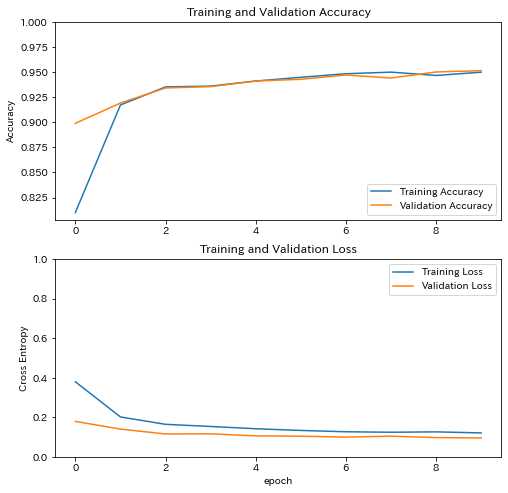

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## validationデータの方がlossが小さいのはvalidationデータの計算ではバッチ正規化やdropoutがオフになるのと、trainデータはエポックの平均を計算しているが、validationデータはエポックごとに計算されるため。

## Fine tuningをする

## 注意点としては最初からfine tuningを行わないこと。勾配が大きすぎて学習済みモデルが崩れてしまうので一度新しく追加した層を数エポック学習させた後でfine tuningを行う。

In [41]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


## さっきより低い学習率を使う

In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [47]:
len(model.trainable_variables)

58

In [48]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/15


    174/Unknown - 28s 28s/step - loss: 0.0881 - accuracy: 0.93 - 30s 15s/step - loss: 0.0695 - accuracy: 0.95 - 32s 11s/step - loss: 0.0747 - accuracy: 0.95 - 33s 8s/step - loss: 0.0880 - accuracy: 0.9609 - 35s 7s/step - loss: 0.0842 - accuracy: 0.962 - 37s 6s/step - loss: 0.0822 - accuracy: 0.968 - 38s 5s/step - loss: 0.0788 - accuracy: 0.973 - 39s 5s/step - loss: 0.0816 - accuracy: 0.972 - 41s 5s/step - loss: 0.0968 - accuracy: 0.961 - 42s 4s/step - loss: 0.0998 - accuracy: 0.959 - 44s 4s/step - loss: 0.1001 - accuracy: 0.957 - 45s 4s/step - loss: 0.1017 - accuracy: 0.953 - 47s 4s/step - loss: 0.0995 - accuracy: 0.954 - 48s 3s/step - loss: 0.0958 - accuracy: 0.957 - 50s 3s/step - loss: 0.0969 - accuracy: 0.956 - 51s 3s/step - loss: 0.0971 - accuracy: 0.953 - 53s 3s/step - loss: 0.0988 - accuracy: 0.955 - 55s 3s/step - loss: 0.0950 - accuracy: 0.958 - 56s 3s/step - loss: 0.0926 - accuracy: 0.960 - 58s 3s/step - loss: 0.0903 - accuracy: 0.962 - 59s 3s/step - loss: 0.0893 - accuracy: 0.

582/582 [==============================]0.0994 - accuracy: 0.959 - 1013s 2s/step - loss: 0.0994 - accuracy: 0.959 - 1015s 2s/step - loss: 0.0993 - accuracy: 0.959 - 1017s 2s/step - loss: 0.0992 - accuracy: 0.959 - 1018s 2s/step - loss: 0.0992 - accuracy: 0.959 - 1021s 2s/step - loss: 0.0990 - accuracy: 0.959 - 1022s 2s/step - loss: 0.0989 - accuracy: 0.959 - 1024s 2s/step - loss: 0.0990 - accuracy: 0.959 - 1025s 2s/step - loss: 0.0993 - accuracy: 0.959 - 1027s 2s/step - loss: 0.0994 - accuracy: 0.959 - 1029s 2s/step - loss: 0.0994 - accuracy: 0.959 - 1030s 2s/step - loss: 0.0994 - accuracy: 0.959 - 1032s 2s/step - loss: 0.0998 - accuracy: 0.959 - 1033s 2s/step - loss: 0.0997 - accuracy: 0.959 - 1035s 2s/step - loss: 0.0996 - accuracy: 0.959 - 1037s 2s/step - loss: 0.0996 - accuracy: 0.959 - 1038s 2s/step - loss: 0.0997 - accuracy: 0.959 - 1040s 2s/step - loss: 0.0998 - accuracy: 0.959 - 1042s 2s/step - loss: 0.0998 - accuracy: 0.959 - 1044s 2s/step - loss: 0.0996 - accuracy: 0.959 - 10

178/582 [========>.....................] - ETA: 48:54 - loss: 0.0762 - accuracy: 0.968 - ETA: 31:21 - loss: 0.0998 - accuracy: 0.953 - ETA: 27:11 - loss: 0.0736 - accuracy: 0.968 - ETA: 24:11 - loss: 0.1481 - accuracy: 0.937 - ETA: 21:58 - loss: 0.1321 - accuracy: 0.937 - ETA: 20:35 - loss: 0.1176 - accuracy: 0.942 - ETA: 20:00 - loss: 0.1120 - accuracy: 0.942 - ETA: 19:20 - loss: 0.1039 - accuracy: 0.945 - ETA: 18:47 - loss: 0.0979 - accuracy: 0.947 - ETA: 18:22 - loss: 0.0952 - accuracy: 0.953 - ETA: 18:13 - loss: 0.0902 - accuracy: 0.954 - ETA: 17:52 - loss: 0.0849 - accuracy: 0.958 - ETA: 17:40 - loss: 0.0800 - accuracy: 0.959 - ETA: 17:24 - loss: 0.0779 - accuracy: 0.959 - ETA: 17:19 - loss: 0.0813 - accuracy: 0.958 - ETA: 17:06 - loss: 0.0777 - accuracy: 0.960 - ETA: 16:47 - loss: 0.0750 - accuracy: 0.963 - ETA: 16:26 - loss: 0.0721 - accuracy: 0.965 - ETA: 16:08 - loss: 0.0738 - accuracy: 0.963 - ETA: 16:01 - loss: 0.0721 - accuracy: 0.964 - ETA: 15:51 - loss: 0.0692 - accuracy:

582/582 [==============================] - ETA: 45s - loss: 0.0692 - accuracy: 0.971 - ETA: 43s - loss: 0.0694 - accuracy: 0.971 - ETA: 42s - loss: 0.0697 - accuracy: 0.971 - ETA: 41s - loss: 0.0700 - accuracy: 0.971 - ETA: 39s - loss: 0.0699 - accuracy: 0.971 - ETA: 38s - loss: 0.0698 - accuracy: 0.971 - ETA: 36s - loss: 0.0697 - accuracy: 0.971 - ETA: 35s - loss: 0.0696 - accuracy: 0.971 - ETA: 33s - loss: 0.0697 - accuracy: 0.971 - ETA: 32s - loss: 0.0697 - accuracy: 0.971 - ETA: 30s - loss: 0.0704 - accuracy: 0.971 - ETA: 29s - loss: 0.0703 - accuracy: 0.971 - ETA: 27s - loss: 0.0704 - accuracy: 0.971 - ETA: 26s - loss: 0.0704 - accuracy: 0.971 - ETA: 24s - loss: 0.0705 - accuracy: 0.971 - ETA: 23s - loss: 0.0704 - accuracy: 0.971 - ETA: 21s - loss: 0.0703 - accuracy: 0.971 - ETA: 20s - loss: 0.0703 - accuracy: 0.971 - ETA: 19s - loss: 0.0702 - accuracy: 0.971 - ETA: 17s - loss: 0.0701 - accuracy: 0.971 - ETA: 16s - loss: 0.0700 - accuracy: 0.971 - ETA: 14s - loss: 0.0701 - accurac

178/582 [========>.....................] - ETA: 44:33 - loss: 0.0352 - accuracy: 0.968 - ETA: 28:56 - loss: 0.0262 - accuracy: 0.984 - ETA: 24:44 - loss: 0.0357 - accuracy: 0.989 - ETA: 22:21 - loss: 0.0282 - accuracy: 0.992 - ETA: 20:34 - loss: 0.0263 - accuracy: 0.993 - ETA: 19:36 - loss: 0.0253 - accuracy: 0.994 - ETA: 18:59 - loss: 0.0261 - accuracy: 0.995 - ETA: 18:18 - loss: 0.0460 - accuracy: 0.984 - ETA: 17:44 - loss: 0.0444 - accuracy: 0.982 - ETA: 17:23 - loss: 0.0436 - accuracy: 0.981 - ETA: 17:10 - loss: 0.0404 - accuracy: 0.983 - ETA: 16:50 - loss: 0.0430 - accuracy: 0.981 - ETA: 16:36 - loss: 0.0460 - accuracy: 0.978 - ETA: 16:34 - loss: 0.0461 - accuracy: 0.977 - ETA: 16:28 - loss: 0.0444 - accuracy: 0.979 - ETA: 16:16 - loss: 0.0447 - accuracy: 0.980 - ETA: 16:05 - loss: 0.0428 - accuracy: 0.981 - ETA: 15:58 - loss: 0.0438 - accuracy: 0.980 - ETA: 15:51 - loss: 0.0463 - accuracy: 0.980 - ETA: 15:42 - loss: 0.0449 - accuracy: 0.981 - ETA: 15:33 - loss: 0.0557 - accuracy:

582/582 [==============================] - ETA: 50s - loss: 0.0538 - accuracy: 0.979 - ETA: 48s - loss: 0.0537 - accuracy: 0.979 - ETA: 47s - loss: 0.0536 - accuracy: 0.979 - ETA: 45s - loss: 0.0536 - accuracy: 0.979 - ETA: 44s - loss: 0.0535 - accuracy: 0.979 - ETA: 42s - loss: 0.0537 - accuracy: 0.979 - ETA: 41s - loss: 0.0538 - accuracy: 0.979 - ETA: 39s - loss: 0.0547 - accuracy: 0.979 - ETA: 37s - loss: 0.0546 - accuracy: 0.979 - ETA: 36s - loss: 0.0548 - accuracy: 0.979 - ETA: 34s - loss: 0.0547 - accuracy: 0.979 - ETA: 33s - loss: 0.0548 - accuracy: 0.979 - ETA: 31s - loss: 0.0548 - accuracy: 0.979 - ETA: 29s - loss: 0.0547 - accuracy: 0.979 - ETA: 28s - loss: 0.0546 - accuracy: 0.979 - ETA: 26s - loss: 0.0546 - accuracy: 0.979 - ETA: 25s - loss: 0.0548 - accuracy: 0.979 - ETA: 23s - loss: 0.0550 - accuracy: 0.979 - ETA: 22s - loss: 0.0550 - accuracy: 0.979 - ETA: 20s - loss: 0.0549 - accuracy: 0.979 - ETA: 18s - loss: 0.0551 - accuracy: 0.979 - ETA: 17s - loss: 0.0550 - accurac

178/582 [========>.....................] - ETA: 37:13 - loss: 0.0078 - accuracy: 1.000 - ETA: 26:23 - loss: 0.0173 - accuracy: 1.000 - ETA: 22:48 - loss: 0.0478 - accuracy: 0.989 - ETA: 20:48 - loss: 0.0546 - accuracy: 0.976 - ETA: 19:38 - loss: 0.0476 - accuracy: 0.981 - ETA: 18:53 - loss: 0.0405 - accuracy: 0.984 - ETA: 18:28 - loss: 0.0356 - accuracy: 0.986 - ETA: 18:22 - loss: 0.0400 - accuracy: 0.984 - ETA: 18:17 - loss: 0.0362 - accuracy: 0.986 - ETA: 18:07 - loss: 0.0388 - accuracy: 0.984 - ETA: 17:51 - loss: 0.0367 - accuracy: 0.985 - ETA: 17:33 - loss: 0.0409 - accuracy: 0.981 - ETA: 17:31 - loss: 0.0430 - accuracy: 0.978 - ETA: 17:31 - loss: 0.0411 - accuracy: 0.979 - ETA: 17:29 - loss: 0.0394 - accuracy: 0.981 - ETA: 17:24 - loss: 0.0378 - accuracy: 0.982 - ETA: 17:20 - loss: 0.0437 - accuracy: 0.979 - ETA: 17:12 - loss: 0.0419 - accuracy: 0.980 - ETA: 17:00 - loss: 0.0401 - accuracy: 0.981 - ETA: 16:56 - loss: 0.0391 - accuracy: 0.982 - ETA: 16:47 - loss: 0.0375 - accuracy:

582/582 [==============================] - ETA: 51s - loss: 0.0457 - accuracy: 0.981 - ETA: 50s - loss: 0.0459 - accuracy: 0.981 - ETA: 48s - loss: 0.0459 - accuracy: 0.981 - ETA: 47s - loss: 0.0458 - accuracy: 0.981 - ETA: 45s - loss: 0.0461 - accuracy: 0.981 - ETA: 43s - loss: 0.0460 - accuracy: 0.981 - ETA: 42s - loss: 0.0459 - accuracy: 0.981 - ETA: 40s - loss: 0.0459 - accuracy: 0.981 - ETA: 39s - loss: 0.0459 - accuracy: 0.981 - ETA: 37s - loss: 0.0459 - accuracy: 0.981 - ETA: 36s - loss: 0.0459 - accuracy: 0.981 - ETA: 34s - loss: 0.0460 - accuracy: 0.981 - ETA: 32s - loss: 0.0459 - accuracy: 0.981 - ETA: 31s - loss: 0.0465 - accuracy: 0.981 - ETA: 29s - loss: 0.0464 - accuracy: 0.981 - ETA: 28s - loss: 0.0464 - accuracy: 0.981 - ETA: 26s - loss: 0.0463 - accuracy: 0.981 - ETA: 25s - loss: 0.0463 - accuracy: 0.981 - ETA: 23s - loss: 0.0463 - accuracy: 0.981 - ETA: 21s - loss: 0.0462 - accuracy: 0.981 - ETA: 20s - loss: 0.0462 - accuracy: 0.981 - ETA: 18s - loss: 0.0461 - accurac

178/582 [========>.....................] - ETA: 41:37 - loss: 0.0142 - accuracy: 1.000 - ETA: 28:14 - loss: 0.0103 - accuracy: 1.000 - ETA: 24:06 - loss: 0.0733 - accuracy: 0.968 - ETA: 21:34 - loss: 0.0620 - accuracy: 0.976 - ETA: 19:56 - loss: 0.0553 - accuracy: 0.981 - ETA: 18:45 - loss: 0.0499 - accuracy: 0.979 - ETA: 18:00 - loss: 0.0442 - accuracy: 0.982 - ETA: 17:34 - loss: 0.0429 - accuracy: 0.980 - ETA: 16:49 - loss: 0.0387 - accuracy: 0.982 - ETA: 16:25 - loss: 0.0355 - accuracy: 0.984 - ETA: 16:02 - loss: 0.0329 - accuracy: 0.985 - ETA: 16:05 - loss: 0.0324 - accuracy: 0.987 - ETA: 15:56 - loss: 0.0304 - accuracy: 0.988 - ETA: 15:45 - loss: 0.0290 - accuracy: 0.988 - ETA: 15:37 - loss: 0.0277 - accuracy: 0.989 - ETA: 15:34 - loss: 0.0274 - accuracy: 0.990 - ETA: 15:24 - loss: 0.0260 - accuracy: 0.990 - ETA: 15:15 - loss: 0.0281 - accuracy: 0.991 - ETA: 15:11 - loss: 0.0291 - accuracy: 0.990 - ETA: 15:06 - loss: 0.0282 - accuracy: 0.990 - ETA: 15:00 - loss: 0.0291 - accuracy:

582/582 [==============================] - ETA: 50s - loss: 0.0382 - accuracy: 0.985 - ETA: 48s - loss: 0.0383 - accuracy: 0.985 - ETA: 47s - loss: 0.0383 - accuracy: 0.985 - ETA: 45s - loss: 0.0382 - accuracy: 0.985 - ETA: 43s - loss: 0.0382 - accuracy: 0.985 - ETA: 42s - loss: 0.0381 - accuracy: 0.985 - ETA: 40s - loss: 0.0381 - accuracy: 0.985 - ETA: 39s - loss: 0.0382 - accuracy: 0.985 - ETA: 37s - loss: 0.0382 - accuracy: 0.985 - ETA: 36s - loss: 0.0382 - accuracy: 0.985 - ETA: 34s - loss: 0.0382 - accuracy: 0.985 - ETA: 32s - loss: 0.0382 - accuracy: 0.985 - ETA: 31s - loss: 0.0384 - accuracy: 0.985 - ETA: 29s - loss: 0.0384 - accuracy: 0.985 - ETA: 28s - loss: 0.0383 - accuracy: 0.985 - ETA: 26s - loss: 0.0382 - accuracy: 0.985 - ETA: 25s - loss: 0.0382 - accuracy: 0.985 - ETA: 23s - loss: 0.0381 - accuracy: 0.985 - ETA: 21s - loss: 0.0381 - accuracy: 0.985 - ETA: 20s - loss: 0.0381 - accuracy: 0.985 - ETA: 18s - loss: 0.0381 - accuracy: 0.985 - ETA: 17s - loss: 0.0383 - accurac

178/582 [========>.....................] - ETA: 46:19 - loss: 0.0071 - accuracy: 1.000 - ETA: 30:45 - loss: 0.0066 - accuracy: 1.000 - ETA: 25:42 - loss: 0.0193 - accuracy: 1.000 - ETA: 23:30 - loss: 0.0153 - accuracy: 1.000 - ETA: 22:10 - loss: 0.0127 - accuracy: 1.000 - ETA: 20:58 - loss: 0.0133 - accuracy: 1.000 - ETA: 20:27 - loss: 0.0141 - accuracy: 1.000 - ETA: 20:20 - loss: 0.0148 - accuracy: 1.000 - ETA: 19:40 - loss: 0.0138 - accuracy: 1.000 - ETA: 19:24 - loss: 0.0144 - accuracy: 1.000 - ETA: 19:07 - loss: 0.0138 - accuracy: 1.000 - ETA: 18:50 - loss: 0.0131 - accuracy: 1.000 - ETA: 18:31 - loss: 0.0135 - accuracy: 0.997 - ETA: 18:33 - loss: 0.0163 - accuracy: 0.995 - ETA: 18:15 - loss: 0.0174 - accuracy: 0.993 - ETA: 17:58 - loss: 0.0164 - accuracy: 0.994 - ETA: 17:55 - loss: 0.0155 - accuracy: 0.994 - ETA: 17:44 - loss: 0.0148 - accuracy: 0.994 - ETA: 17:35 - loss: 0.0145 - accuracy: 0.995 - ETA: 17:30 - loss: 0.0142 - accuracy: 0.995 - ETA: 17:26 - loss: 0.0137 - accuracy:

582/582 [==============================] - ETA: 53s - loss: 0.0285 - accuracy: 0.988 - ETA: 51s - loss: 0.0285 - accuracy: 0.988 - ETA: 50s - loss: 0.0284 - accuracy: 0.988 - ETA: 48s - loss: 0.0285 - accuracy: 0.988 - ETA: 47s - loss: 0.0285 - accuracy: 0.988 - ETA: 45s - loss: 0.0286 - accuracy: 0.988 - ETA: 43s - loss: 0.0287 - accuracy: 0.988 - ETA: 42s - loss: 0.0286 - accuracy: 0.988 - ETA: 40s - loss: 0.0286 - accuracy: 0.988 - ETA: 38s - loss: 0.0287 - accuracy: 0.988 - ETA: 37s - loss: 0.0287 - accuracy: 0.988 - ETA: 35s - loss: 0.0291 - accuracy: 0.988 - ETA: 34s - loss: 0.0291 - accuracy: 0.988 - ETA: 32s - loss: 0.0291 - accuracy: 0.988 - ETA: 30s - loss: 0.0290 - accuracy: 0.988 - ETA: 29s - loss: 0.0290 - accuracy: 0.988 - ETA: 27s - loss: 0.0291 - accuracy: 0.988 - ETA: 25s - loss: 0.0290 - accuracy: 0.988 - ETA: 24s - loss: 0.0290 - accuracy: 0.988 - ETA: 22s - loss: 0.0291 - accuracy: 0.988 - ETA: 21s - loss: 0.0291 - accuracy: 0.988 - ETA: 19s - loss: 0.0291 - accurac

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

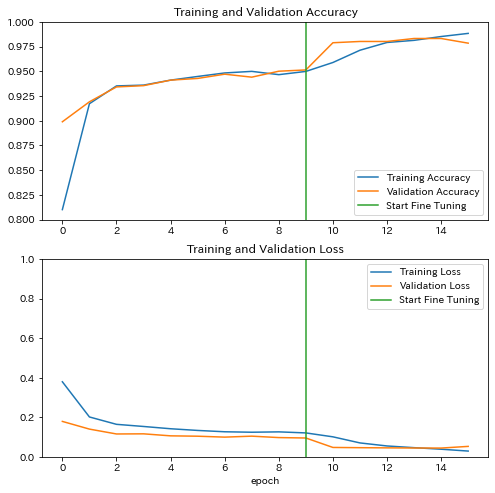

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()